In [3]:
import pandas as pd
import stanza
import string
import time
import re
import nltk
import numpy as np

df = pd.read_excel("./Exports/export_excel.xlsx")

In [28]:
df2 = pd.DataFrame()
df2["xpo"] = ["" for i in range(len(df))]

for i in range(len(df)):
    if pd.isna(df["Exposé des motifs"][i]) == False:
        df2["xpo"][i] = df["Exposé des motifs"][i]
#        print("it")
    elif pd.isna(df["Exposé des motifs"][i]) == True and pd.isna(df["Communiqué de presse"][i]) == False:
        df2["xpo"][i] = df["Communiqué de presse"][i]

df2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xpo
0,
1,La France a signé le 18 décembre 2008 à Paris...
2,"NOR : INTX1232040L Depuis 1986, la France s'e..."
3,
4,Le présent projet de loi poursuit deux object...
...,...
740,
741,Le ministre des finances et des comptes public...
742,ExposÉ des motifs Le projet de loi qui vous e...
743,Représentant de la Nation et garant du foncti...


In [29]:
df2 = df2.loc[df2.xpo != ""]
df2.reset_index(inplace=True, drop=True)
#df2 = df2.iloc[:,1]
df2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,xpo
0,La France a signé le 18 décembre 2008 à Paris...
1,"NOR : INTX1232040L Depuis 1986, la France s'e..."
2,Le présent projet de loi poursuit deux object...
3,L'activité législative soutenue du Conseil de...
4,Le titre I er du projet de loi transpose la d...
...,...
467,"La ministre du budget, des comptes publics et ..."
468,Le ministre des finances et des comptes public...
469,ExposÉ des motifs Le projet de loi qui vous e...
470,Représentant de la Nation et garant du foncti...


In [30]:
nlp = stanza.Pipeline('fr')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-12-22 13:58:41 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-12-22 13:58:41 INFO: Use device: cpu
2021-12-22 13:58:41 INFO: Loading: tokenize
2021-12-22 13:58:41 INFO: Loading: mwt
2021-12-22 13:58:41 INFO: Loading: pos
2021-12-22 13:58:42 INFO: Loading: lemma
2021-12-22 13:58:42 INFO: Loading: depparse
2021-12-22 13:58:43 INFO: Loading: ner
2021-12-22 13:58:46 INFO: Done loading processors!


In [6]:
with open("./stopwords/Stop-words-french.txt", "r", encoding='utf8') as f:
    stopW1 = [line.rstrip("\n") for line in f.readlines()]
with open("./stopwords/stopword.txt", "r", encoding='utf8') as f:
    stopW2 = [line.rstrip("\n") for line in f.readlines()]
with open("./stopwords/stopwords_topics.txt", "r", encoding='utf8') as f:
    stopW3 = [line.rstrip("\n") for line in f.readlines()]
stopW = stopW1 + stopW2 + stopW3 #+ stopwords.words("french")
stopW.extend(string.punctuation)
stopW.extend(['’', '«', '»', '…', '—','».', '»,', '---', '.—', '…—', 'ans', 'an'])

In [11]:
xpo = []
for i in range(len(df2)):
    xpo.append(df2.xpo[i])

for i in range(len(xpo)):
    start = time.time()
    doc = nlp(xpo[i])
    sent = []
    for j, sentence in enumerate(doc.sentences):
        sent.append((j, [word.lemma for word in sentence.words if word.lemma.lower() not in stopW and word.lemma.lower() != "l'"]))
        xpo[i] = dict(sent)
    end = time.time()
    print("Temps {:.5}s".format(end-start), len(xpo)-i)

Temps 25.079s 472
Temps 21.08s 471
Temps 56.038s 470
Temps 71.583s 469
Temps 8.975s 468
Temps 43.368s 467
Temps 56.897s 466
Temps 15.0s 465
Temps 62.143s 464
Temps 24.888s 463
Temps 24.583s 462
Temps 9.9331s 461
Temps 59.174s 460
Temps 64.246s 459
Temps 59.959s 458
Temps 61.056s 457
Temps 9.8755s 456
Temps 10.873s 455
Temps 58.931s 454
Temps 6.7218s 453
Temps 15.493s 452
Temps 5.0733s 451
Temps 30.327s 450
Temps 11.925s 449
Temps 26.152s 448
Temps 53.409s 447
Temps 69.787s 446
Temps 65.696s 445
Temps 61.906s 444
Temps 27.841s 443
Temps 63.467s 442
Temps 56.39s 441
Temps 19.953s 440
Temps 3.7829s 439
Temps 31.753s 438
Temps 10.035s 437
Temps 6.2731s 436
Temps 56.794s 435
Temps 20.081s 434
Temps 11.727s 433
Temps 61.114s 432
Temps 38.997s 431
Temps 13.836s 430
Temps 3.4279s 429
Temps 143.33s 428
Temps 30.83s 427
Temps 74.496s 426
Temps 7.4761s 425
Temps 2.8409s 424
Temps 10.579s 423
Temps 6.4097s 422
Temps 68.286s 421
Temps 24.982s 420
Temps 45.602s 419
Temps 39.8s 418
Temps 47.709s 417


Temps 3.5736s 8
Temps 7.6751s 7
Temps 5.3294s 6
Temps 8.7409s 5
Temps 4.4358s 4
Temps 22.288s 3
Temps 13.324s 2
Temps 17.52s 1


In [15]:
dataf = pd.DataFrame(xpo)
dataf.to_excel("./Exports/sentences_lemma.xlsx")

In [7]:
xpo2 = pd.read_excel("./Exports/sentences_lemma.xlsx", index_col=0)

i, j = xpo2.shape
print(i, j)

for x in range(i):
    for y in range(j):
        if pd.isna(xpo2[y][x]) == True:
            continue
        else:
            sent = xpo2[y][x]
            sent = ''.join(sent)

            sent = re.sub('\'', '', sent)
            sent = re.sub('\]', '', sent)
            sent = re.sub('\[', '', sent)

            sent = sent.split(', ')
            xpo2[y][x] = sent

xpo2

472 209


,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,"[France, signer, 18, 2008, Paris, accord, agen...","[objet, accord, préciser, 2]","[prévoir, modalité, terrain, CSG, agence, préc...","[3, préciser, engagement, obligation, gouverne...","[France, garantir, abord, centre, national, ét...","[France, responsabilité, infrastructure, base,...","[charge, prendre, sauvegarde, sûreté, CSG, ass...","[accord, prévoir, agence, pouvoir, consulter, ...","[devoir, informer, agence, préalablement, refu...","[France, responsabilité, direct, protection, e...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[INTX1232040L, 1986, France, progressivement, ...","[efficace, devoir, permanence, adapter, évolut...","[contexte, où, menace, terroriste, demeurer, é...","[aller, police, administratif, introduire, 3, ...","[prévoir, expérimental, législateur, durée, re...","[nouveau, prorogation, souci, constant, concil...","[pénal, compléter, français, appliquer, incond...","[modification, poursuivre, efficacement, perso...","[modifier, entrée, séjour, étranger, asile, CE...","[L., 521-3, CESEDA, expulsion, étranger, majeu...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[présent, poursuivre, objectif, améliorer, par...","[I., relatif, participation, citoyen, fonction...","[participation, citoyen, fonctionnement, justi...","[assurer, décision, juridictionnel, déconnecte...","[renforcer, lien, devant, exister, population,...","[raison, lequel, présent, objectif, participat...","[fin, procéder, série, modification]","[premier, lieu, prévoir, jugement, délit, port...","[dernier, accomplir, devoir, civique]","[deuxième, lieu, prévoir, jugement, premier, r...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[activité, législatif, soutenir, conseil, unio...","[importance, réforme, agir, essentiel, consoli...","[présent, rassembler, œuvre, national, réforme]","[1er, relatif, transposition, directive, 2014,...","[directive, viser, doter, pouvoir, public, nou...","[habiliter, gouvernement, prendre, ordonnance,...","[2, relatif, transposition, directive, 2014, 4...","[directive, précité, substituer, directive, 20...","[directive, 2014, 49, UE, viser, harmoniser, n...","[fin, prévoir, plusieurs, modification, import...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[er, transposer, directive, 2003, 72, conseil,...","[statut, société, coopératif, européen, concev...","[nouveau, devoir, porter, atteindre, travaille...","[communautaire, directive, indissociable, préa...","[directive, articuler, autour, principe, évite...","[agir, principe, -après]","[imposer, règle, inconnu, conforme, système, r...","[présent, transposition, inspirer, largement, ...","[réserver, traitement, particulier, petit, soc...","[prévoir, conseil, préciser, modalité, applica...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,"[ministre, public, réforme, porte-parole, gouv...","[réduction, endettement, public, priorité]","[passer, abord, réduction, déficit, public]","[finance, 2012, confirmer, égard, caractère, i...","[déficit, public, ramener, 5,7, 2011, 4,5, 201...","[France, entamer, désendettement, dès, 2013, r...","[2012, gouvernement, choisir, retenir, hypothè...","[choix, répondre, souci, prudence, contexte, c...","[dépit, fondamental, économique, solide, Franc...","[gouvernement, constater, demande, intérieur, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
468,"[ministre, finance, public, secrétaire, charge...","[résultat, obtenir, 2014, montrer, effort, dem...","[déficit, public, situer, 4, PIB, continuer, r...","[nettement, inférieur, prévision, 4,4, reposer...","[déficit, structurel, éliminer, cycle, économi...","[résultat, obtenir, grâce, gestion, sérieux, d...","[dépense, dépense, exceptionnel, charge, intér...","[diminution, tel, ampleur, précédent, instaura...","[total, dépense, ensemble, administration, pub...","[progression, historiquement, bas]",...,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
dat = [x for i in xpo2.index for x in xpo2.iloc[i] if x is not np.nan]
for i in range(len(dat)):
#        print(dat[i])
    sent = re.sub(r'[^A-Za-zÀ-ÿ-’\' ]+', '', ' '.join(dat[i]))
    sent = nltk.word_tokenize(sent)
    stop_doc = [word for word in sent if word not in stopW]
    dat[i] = stop_doc
    
dat[0:500]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['France',
  'signer',
  'Paris',
  'accord',
  'agence',
  'spatial',
  'européen',
  'ci-après',
  'dénommer',
  'ASE',
  'agence',
  'centre',
  'spatial',
  'guyanais',
  'CSG',
  'prestation',
  'associer'],
 ['objet', 'accord', 'préciser'],
 ['modalité',
  'terrain',
  'CSG',
  'agence',
  'préciser',
  'relation',
  'partie',
  'obligation',
  'réciproque',
  'modalité',
  'selon',
  'lequel',
  'gouvernement',
  'français',
  'garantir',
  'disponibilité',
  'ensemble',
  'soutien',
  'lancement',
  'CSG',
  'fin',
  'programme',
  'ASE',
  'phase',
  'exploitation',
  'lanceur',
  'Ariane',
  'Vega',
  'Soyouz'],
 ['préciser',
  'engagement',
  'obligation',
  'gouvernement',
  'français',
  'vis-à-vis',
  'agence'],
 ['France',
  'garantir',
  'abord',
  'centre',
  'national',
  'étude',
  'spatial',
  'CNES',
  'mettre',
  'gratuitement',
  'ASE',
  'terrain',
  'CSG'],
 ['France',
  'responsabilité',
  'infrastructure',
  'base',
  'département',
  'Guyane',
  'fonctionne

In [11]:
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import  Word2Vec
import gensim
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import cm 
from gensim.utils import simple_preprocess
import pyLDAvis
from pyLDAvis import gensim_models
from gensim.models.ldamodel import LdaModel
import logging

In [13]:
data = dat

# création du dictionnaire
dico = corpora.Dictionary(data)

# ce qui permet par ex. de filtrer le vocabulaire
dico.filter_extremes(no_below=10)

# Create Corpus
texts = data

# matrice Term Document Frequency
corpus = [dico.doc2bow(text) for text in texts]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#ntopics = 50
ntopics = 20

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
generate_lda = False

if generate_lda:
    print("generate new LDA model")
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    ldamodel = LdaModel(corpus, num_topics=ntopics, id2word = dico,
                                           passes=2, random_state=100, per_word_topics=True)
    print(ldamodel)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
from gensim.test.utils import datapath

temp_file = datapath("model20_lemma2") #"model20_lemma"

if generate_lda:
    ldamodel.save(temp_file)
else:
    ldamodel = LdaModel.load(temp_file) 
    print('loaded')

loaded


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
pwz = ldamodel.get_topics()

print("On peut récupérer la matrice stockant p(w/z):", pwz.shape)

On peut récupérer la matrice stockant p(w/z): (20, 3636)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
ldamodel.show_topics(num_topics=ntopics,formatted=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('conseil', 0.036280118),
   ('président', 0.033400968),
   ('république', 0.030499754),
   ('français', 0.029723737),
   ('pouvoir', 0.027726753),
   ('assemblée', 0.021786852),
   ('organique', 0.01831687),
   ('décision', 0.016504608),
   ('préciser', 0.015600299),
   ('gouvernement', 0.014704716)]),
 (1,
  [('aide', 0.02515947),
   ('champ', 0.018622272),
   ('développement', 0.0150956055),
   ('aménagement', 0.013584263),
   ('plan', 0.013472006),
   ('critère', 0.01292479),
   ('exploitation', 0.012493395),
   ('commerce', 0.01190348),
   ('reconnaissance', 0.011512872),
   ('durable', 0.011027033)]),
 (2,
  [('référence', 0.018352896),
   ('proposition', 0.016810257),
   ('transparence', 0.016369186),
   ('énergie', 0.016083725),
   ('déchet', 0.014951655),
   ('durée', 0.01494372),
   ('supérieur', 0.014483107),
   ('période', 0.014397448),
   ('taux', 0.013655099),
   ('remplacer', 0.01319742)]),
 (3,
  [('établissement', 0.048825618),
   ('contrat', 0.04311152),
   ('

In [13]:
tab = ldamodel.get_topics()
myword = dico.token2id['sécurité']
np.where(tab[:,myword]>0.005)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([ 5, 12, 18]),)

In [563]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, gensim.matutils.corpus2csc(corpus), dictionary=ldamodel.id2word)
#vis
pyLDAvis.display(vis)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



19, 16, 20, 6, 3, ...

In [17]:
ldc = ldamodel[corpus]

def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    i=0
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df_dominant_topic.sort_values("Dominant_Topic", ascending=False)
df_dominant_topic_novoid = df_dominant_topic.loc[df_dominant_topic.Topic_Perc_Contrib > 0.06]
df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
16367,16367,17.0,0.9472,"ministre, modalité, public, présenter, société...","[porter, extension, adaptation, Mayotte, île, ..."
1346,1346,13.0,0.9472,"contre, protection, sanitaire, lutte, environn...","[création, agence, français, biodiversité, pay..."
1125,1125,5.0,0.9441,"public, principe, santé, fonction, sécurité, n...","[texte, outre, quinquennal, objectif, politiqu..."
20621,20621,17.0,0.9367,"ministre, modalité, public, présenter, société...","[ministre, économie, finance, industrie, minis..."
24713,24713,17.0,0.9321,"ministre, modalité, public, présenter, société...","[ministre, économie, finance, ministre, délégu..."
...,...,...,...,...,...
4322,4322,14.0,0.1395,"financier, retraite, investissement, effort, r...","[mettre, jour, environnement, faire, référence..."
18420,18420,11.0,0.1316,"européen, directive, France, parlement, union,...","[tendre, moderniser, susmentionner, sécuriser,..."
2268,2268,14.0,0.1315,"financier, retraite, investissement, effort, r...","[Missions, Crédits, paiement, général, action,..."
16949,16949,3.0,0.1310,"établissement, contrat, public, durée, enseign...","[prolonger, indemnité, départ, volontaire, acc..."


In [171]:
tab = ldamodel.get_topics()
temp = np.where(tab[8,:]>0.009)
temp = [dico[word] for word in temp[0] if dico[word] not in ['élection', 'public', 'nouveau']]

temp2 = np.where(tab[19,:]>0.01)
temp2 = [dico[word] for word in temp2[0] if dico[word] not in ['nouveau', 'transport', 'organisation', 'convention', 'réseau', 'section', 'syndical'
                                                              , "règle", 'personne', 'service', 'public', 'obligation', 'régime']]

print(temp2)
#temp2 = [word for word, prob in ldamodel.show_topic(19) if word not in ['nouveau', 'transport', 'organisation', 'convention']]
top_stop_words = temp+temp2
#top_stop_words
with open("./stopwords/stopwords_topics.txt", "w") as f:
    for word in top_stop_words:
        f.write(word)
        f.write('\n')


['relatif', 'concerner', 'applicable', 'définir', 'introduire', 'modifier', 'II', 'chapitre', 'livre', 'IV', 'Ier']


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0     2526
6.0     2406
9.0     2214
4.0     2155
7.0     1738
19.0    1686
5.0     1682
11.0    1621
18.0    1573
16.0    1502
14.0    1423
17.0    1376
12.0    1356
13.0    1337
3.0     1294
8.0     1252
1.0     1199
15.0    1113
10.0    1084
2.0      697
Name: Dominant_Topic, dtype: int64

## Récupérer les lois associés aux topics

In [19]:
df3 = pd.read_excel("./Exports/final_export.xlsx")
df3 = df3[df3["preprocessed_xpo"].isna() == False]
df3.reset_index(inplace=True, drop=True)
df3 = df3.iloc[:,1:]
for i in range(len(df3)):
    df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))

def get_law(xpo2, dat, nbdoc):

    count = 0
    tmp = {}
    
    for i in range(len(xpo2)):
        for y in range(len(xpo2.iloc[i])):
            if xpo2.iloc[i,y] is np.nan:
                break
            else:
                tmp[count] = i
                count +=1
#    print(tmp)
    
    return(tmp[nbdoc])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-19-75500b2b7226>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.preprocessed_xpo[i] = re.sub("'", "", str(df3.preprocessed_xpo[i]))


In [20]:
count = 0
tmp = {}
    
for i in range(len(xpo2)):
    for y in range(len(xpo2.iloc[i])):
        if xpo2.iloc[i,y] is np.nan:
            break
        else:
            tmp[count] = i
            count +=1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
xpo3 = xpo2
tempo = [[] for i in range(len(df3))]

for i, sent in enumerate(df_dominant_topic_novoid.sort_values("Topic_Perc_Contrib", ascending=False).Document_No):
    temporary = df_dominant_topic_novoid.loc[sent].Dominant_Topic
    tempo[tmp[sent]].append(temporary)
#    print(i, 'reste : ', len(dat)-i, 'topics :', temporary)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
test = pd.DataFrame(tempo)
#test.dropna(thresh=len(tempo)/2, axis=1, inplace=True)
df3['topics'] = [None for i in range(len(xpo3))]

test2 = []

for i in range(len(test)):
    test2.append(test.loc[i].value_counts().index[0])
#    print(i, test.loc[i].value_counts().index[0])
df3.topics = test2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
df3.topics.value_counts() #.plot(kind='bar')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0     58
8.0     54
4.0     40
6.0     37
11.0    36
5.0     34
9.0     28
19.0    26
15.0    20
7.0     20
12.0    17
14.0    17
3.0     14
16.0    14
18.0    12
17.0    12
13.0    11
1.0     10
10.0     9
2.0      3
Name: topics, dtype: int64

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,21.052632,8.108108,20.588235,15.0,14.285714,18.181818,15.909091,5.714286,15.217391,6.060606,12.0,3.703704,3.846154,12.903226,11.111111
1,NaN,NaN,NaN,2.5,2.857143,NaN,2.272727,5.714286,6.521739,NaN,NaN,7.407407,NaN,NaN,NaN
2,5.263158,NaN,NaN,NaN,NaN,NaN,NaN,2.857143,NaN,NaN,4.0,NaN,NaN,NaN,NaN
3,NaN,5.405405,2.941176,5.0,NaN,4.545455,2.272727,NaN,4.347826,3.030303,4.0,NaN,7.692308,3.225806,NaN
4,10.526316,13.513514,2.941176,5.0,20.000000,9.090909,11.363636,5.714286,4.347826,15.151515,4.0,7.407407,7.692308,3.225806,5.555556
5,15.789474,5.405405,8.823529,10.0,14.285714,4.545455,2.272727,2.857143,4.347826,6.060606,20.0,7.407407,NaN,6.451613,5.555556
6,5.263158,21.621622,11.764706,2.5,2.857143,4.545455,4.545455,11.428571,4.347826,3.030303,8.0,11.111111,19.230769,3.225806,5.555556
7,NaN,10.810811,2.941176,2.5,NaN,NaN,4.545455,8.571429,8.695652,6.060606,NaN,3.703704,NaN,6.451613,NaN
8,15.789474,10.810811,8.823529,7.5,14.285714,18.181818,9.090909,11.428571,10.869565,12.121212,8.0,11.111111,11.538462,16.129032,11.111111
9,NaN,NaN,8.823529,5.0,2.857143,9.090909,4.545455,8.571429,4.347826,6.060606,12.0,11.111111,11.538462,6.451613,NaN


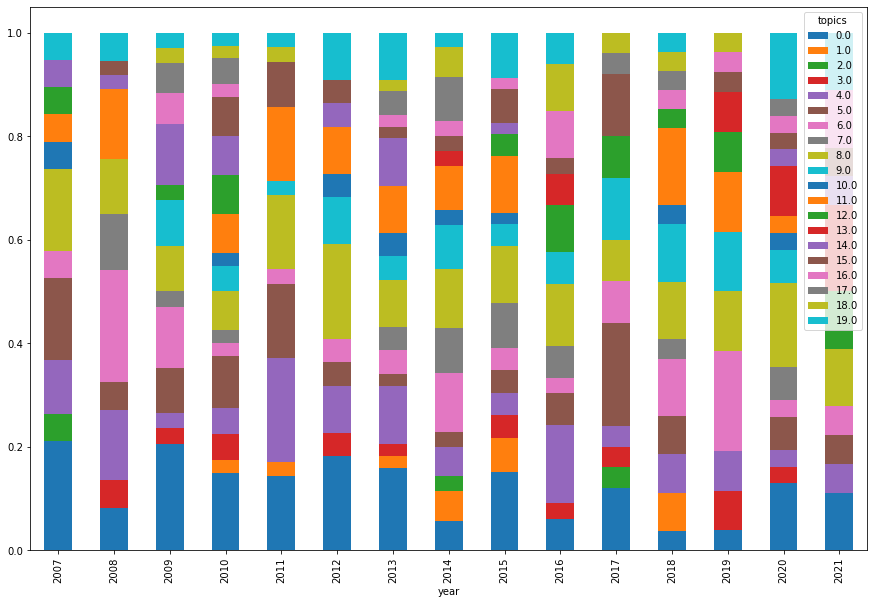

In [146]:
df3.groupby('year').topics.value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,figsize=(15,10), legend=True);  #subplots=True, layout=(5, 4), 
ax = df3.groupby('year').topics.value_counts(normalize=True).mul(100).unstack()

tab = {}

for idx in ax.index:
    test = []
    for i in ax:
        test.append(ax[i].loc[idx])
    test.append(sum(ax.loc[idx].dropna()))
    tab[idx] = test
tab = pd.DataFrame(tab)
tab
#new_df = og_df.groupby(feature)[target].value_counts(normalize=True)
#ax = ax.reset_index()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
2007,6.896552,NaN,33.333333,NaN,5.0,8.823529,2.702703,NaN,5.555556,NaN,11.111111,2.777778,5.882353,NaN,5.882353,NaN,NaN,NaN,NaN,3.846154
2008,5.172414,NaN,NaN,14.285714,12.5,5.882353,21.621622,20.0,7.407407,NaN,NaN,13.888889,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2009,12.068966,NaN,NaN,7.142857,2.5,8.823529,10.810811,5.0,5.555556,10.714286,NaN,NaN,5.882353,NaN,23.529412,NaN,14.285714,16.666667,8.333333,3.846154
2010,10.344828,10.0,NaN,14.285714,5.0,11.764706,2.702703,5.0,5.555556,7.142857,11.111111,8.333333,17.647059,NaN,17.647059,15.0,7.142857,16.666667,8.333333,3.846154
2011,8.620690,10.0,NaN,NaN,17.5,14.705882,2.702703,NaN,9.259259,3.571429,NaN,13.888889,NaN,NaN,NaN,15.0,NaN,NaN,8.333333,3.846154
2012,6.896552,NaN,NaN,7.142857,5.0,2.941176,2.702703,NaN,7.407407,7.142857,11.111111,5.555556,NaN,NaN,5.882353,5.0,NaN,NaN,NaN,7.692308
2013,12.068966,10.0,NaN,7.142857,12.5,2.941176,5.405405,10.0,7.407407,7.142857,22.222222,11.111111,NaN,NaN,23.529412,5.0,7.142857,16.666667,8.333333,15.384615
2014,3.448276,20.0,33.333333,NaN,5.0,2.941176,10.810811,15.0,7.407407,10.714286,11.111111,8.333333,NaN,9.090909,NaN,5.0,7.142857,25.000000,16.666667,3.846154
2015,12.068966,30.0,NaN,14.285714,5.0,5.882353,5.405405,20.0,9.259259,7.142857,11.111111,13.888889,11.764706,NaN,5.882353,15.0,7.142857,NaN,NaN,15.384615
2016,3.448276,NaN,NaN,7.142857,12.5,5.882353,2.702703,10.0,7.407407,7.142857,NaN,NaN,17.647059,18.181818,NaN,5.0,21.428571,NaN,25.000000,7.692308


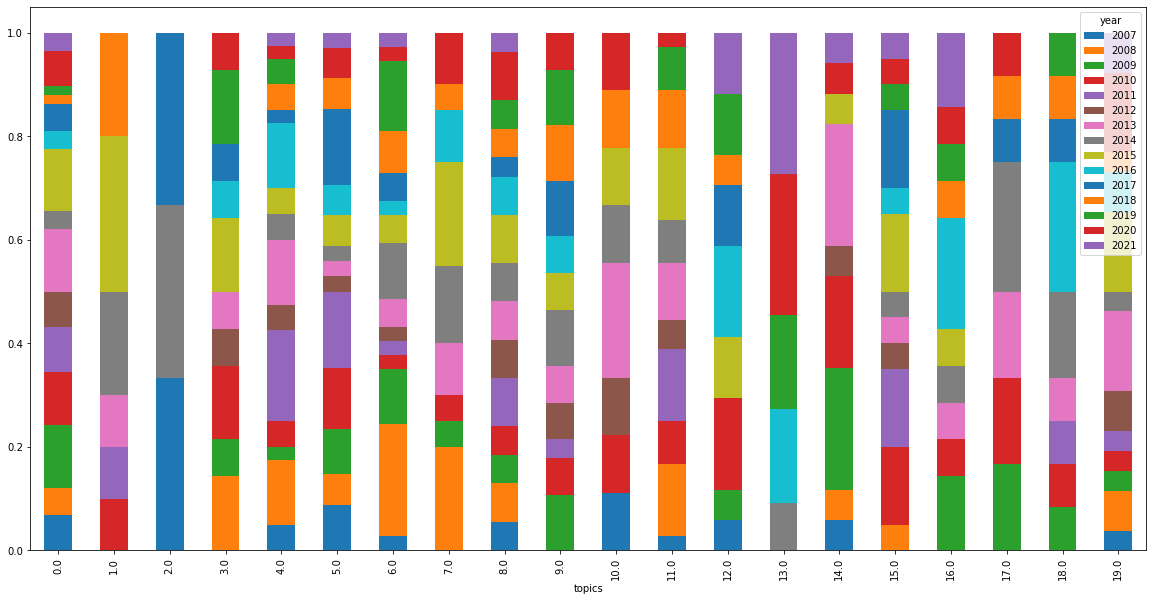

In [152]:
df3.groupby('topics').year.value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                       stacked = True,
                                                                       figsize=(20,10), 
                                                                       legend=True, 
                                                                       ); #subplots=True, layout=(4,5),colormap='Spectral'
ax2 = df3.groupby('topics').year.value_counts(normalize=True).mul(100).unstack()
#Spectral
#rainbow
#prism

tab2 = {}

for idx in ax2.index:
    test2 = []
    for i in ax2:
        test2.append(ax2[i].loc[idx])
    test2.append(sum(ax2.loc[idx].dropna()))
    tab2[idx] = test2
tab2 = pd.DataFrame(tab2)
tab2.transpose()
tab2.index = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 'Total']
tab2

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


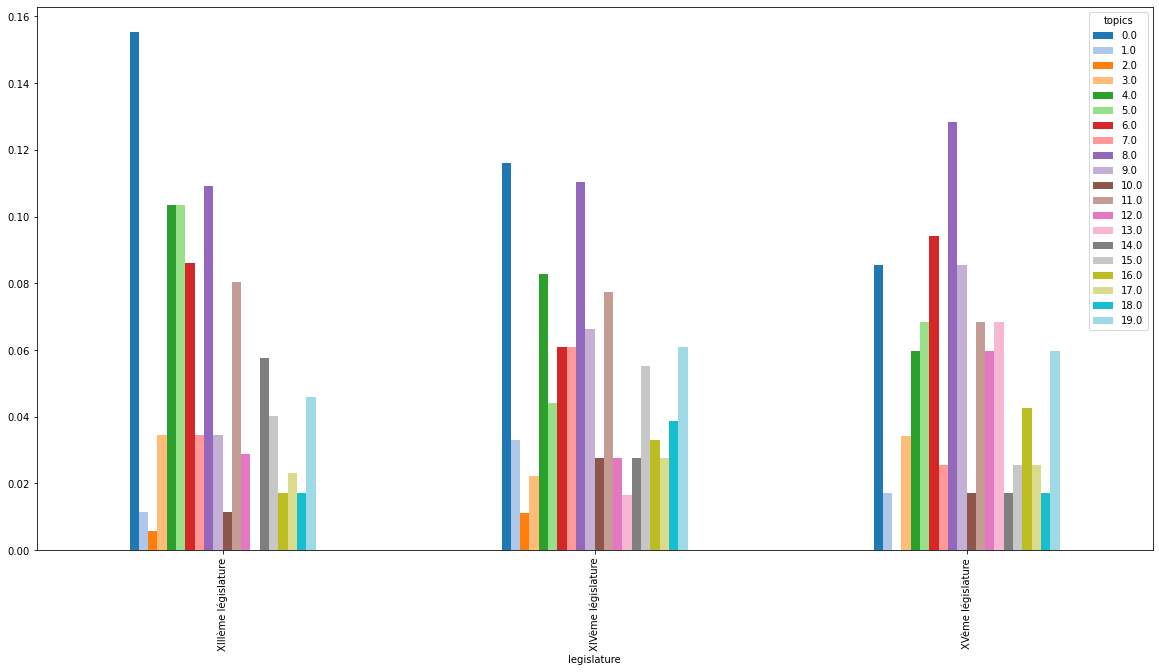

In [181]:
df3.groupby('legislature').topics.value_counts(normalize=True).unstack().plot(kind='bar', 
                                                                        figsize=(20,10),
                                                                        cmap='tab20'
                                                                                     ); #subplots=True, layout=(5,4),

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


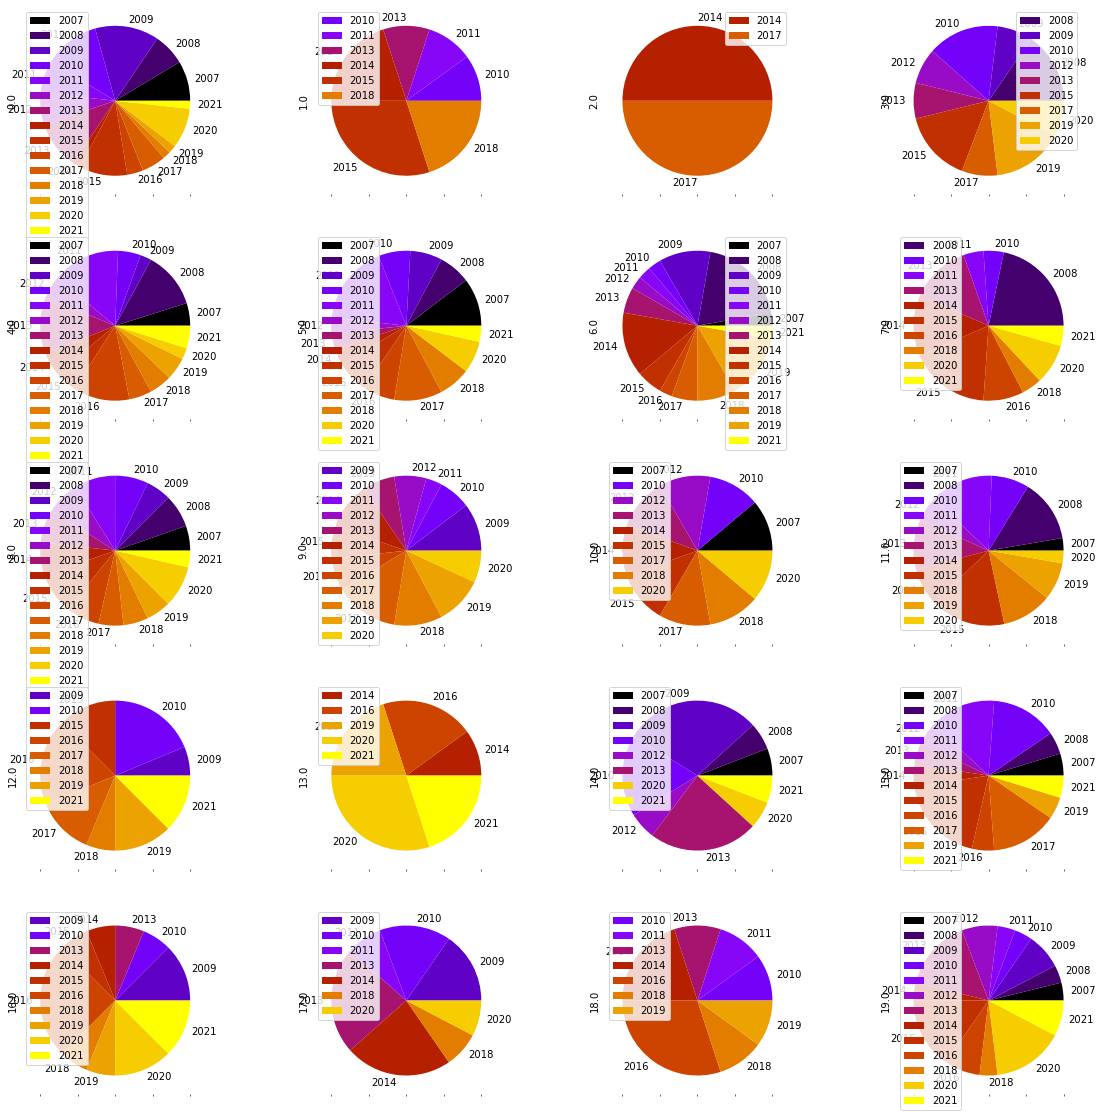

In [501]:
df3.groupby(['year']).topics.value_counts().unstack().plot(kind='pie', figsize=(20,20), subplots=True, layout=(5,4), colormap='gnuplot');
#area
#pie

# Visualisation topic par phrases

In [106]:
senttop = df_dominant_topic_novoid
senttop['year'] = ['' for i in range(len(senttop))]
senttop['legislature'] = ['' for i in range(len(senttop))]

for line in df_dominant_topic_novoid.index:
    senttop['year'].loc[line] = df3.year.loc[tmp[line]]
    senttop['legislature'].loc[line] = df3.legislature.loc[tmp[line]]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-106-7b3407811544>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senttop['year'] = ['' for i in range(len(senttop))]
<ipython-input-106-7b3407811544>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


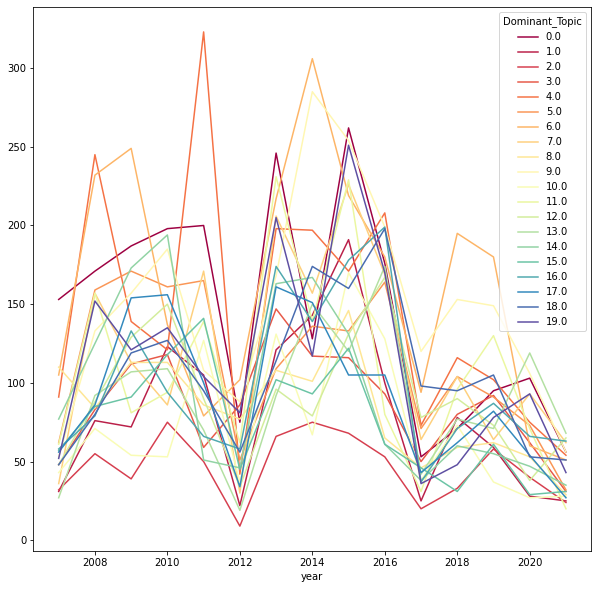

In [107]:
senttop.groupby('year').Dominant_Topic.value_counts().unstack().plot(kind='line', subplots=False, figsize=(10,10), legend=True, cmap='Spectral');

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


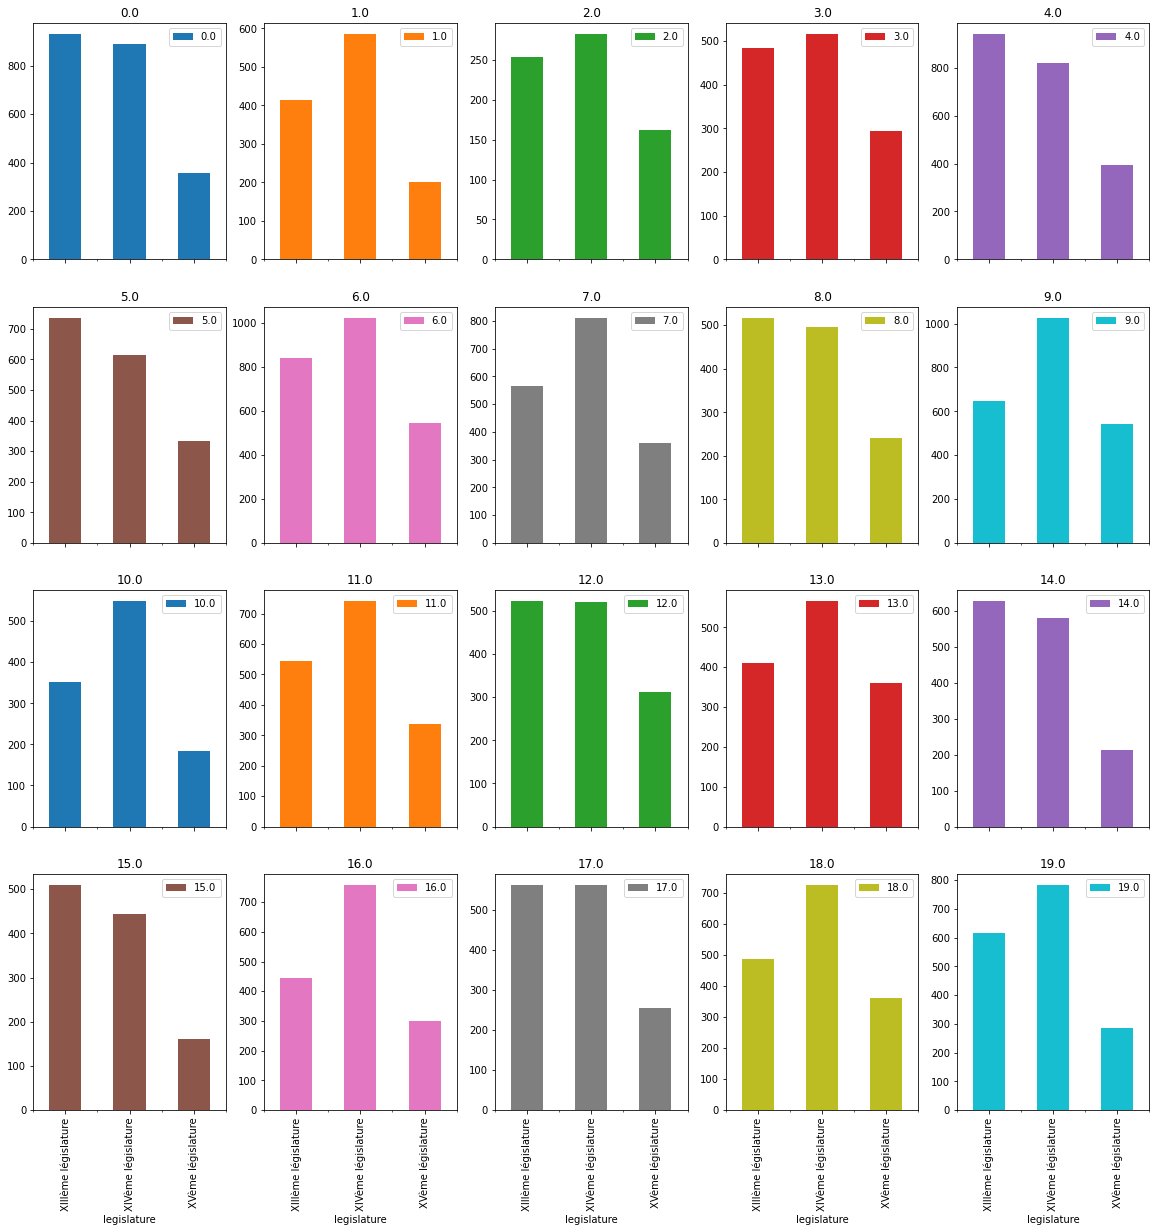

In [57]:
senttop.groupby('legislature').Dominant_Topic.value_counts().unstack().plot(kind='bar', subplots=True, figsize=(20,20), layout=(4, 5), legend=True);

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


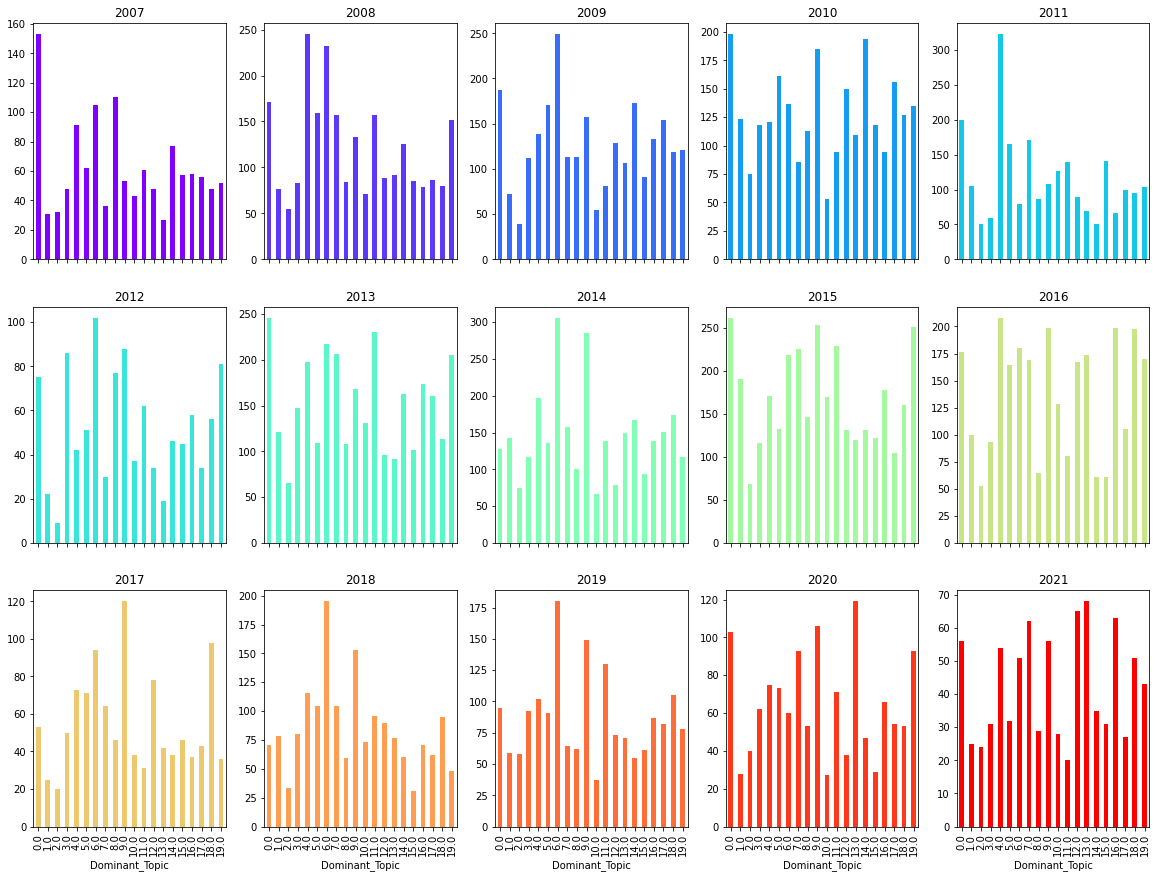

In [67]:
senttop.groupby('Dominant_Topic').year.value_counts().unstack().plot(kind='bar',subplots=True, figsize=(20,20), layout=(4,5), legend=False, colormap='rainbow');

In [83]:
senttop.legislature.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XIVème législature     13285
XIIIème législature    11403
XVème législature       6194
Name: legislature, dtype: int64

# TEST - Collocations en fonction de l'année

On peut choisir des topics en particulier, mais nous travaillons ici sur tous les topics

In [108]:
senttop2 = senttop

#for idx in senttop.index:
#    text = str(senttop.Text.loc[idx])
#    text = re.sub('\[', '', text)
#    text = re.sub('\]', '', text)
#    text = re.sub('\'', '', text)
#    senttop.Text.loc[idx] = text
#senttop

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


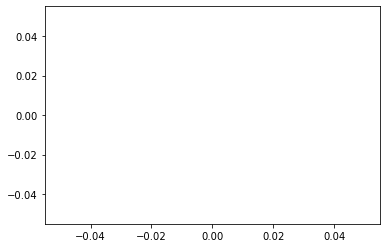

In [146]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = CountVectorizer()

def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

tab = {}

for year in senttop2.year.sort_values().unique():
    fig = plt.plot(subplots=True, layout=(4, 5))
    
    law_x = senttop2.Text.loc[senttop2.year == year]
    tf_vectorizer.fit(law_x)
    X = tf_vectorizer.transform(law_x)
    X = X.toarray()
    features = tf_vectorizer.get_feature_names()

    (num_doc, num_f) = X.shape

    tf_sum = np.sum(X, axis=0)
    tf = top_feats(tf_sum, features, 50)
    top_feats(tf_sum, features, 50)

    tf.index = tf.feature
    tab[year] = tf

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


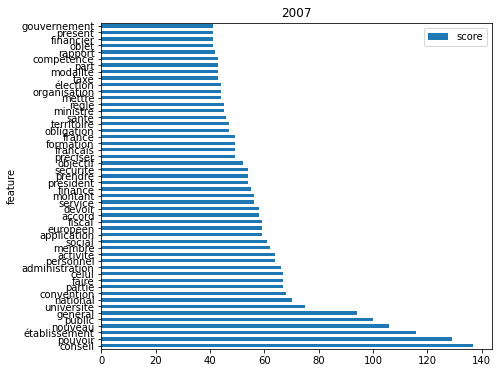

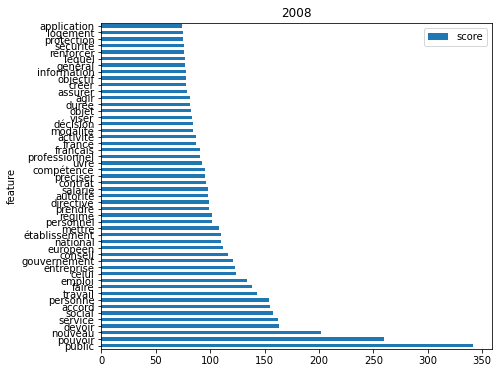

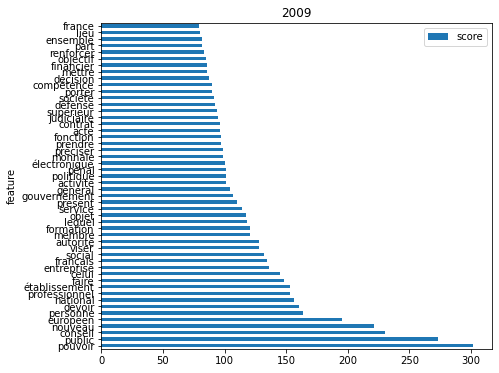

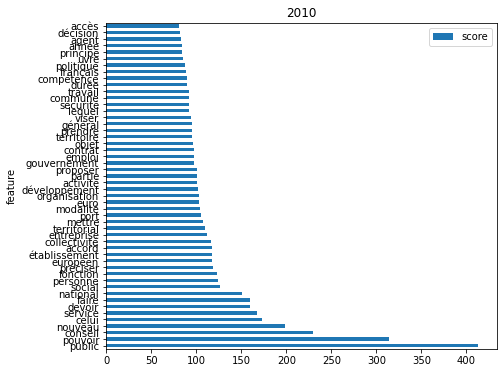

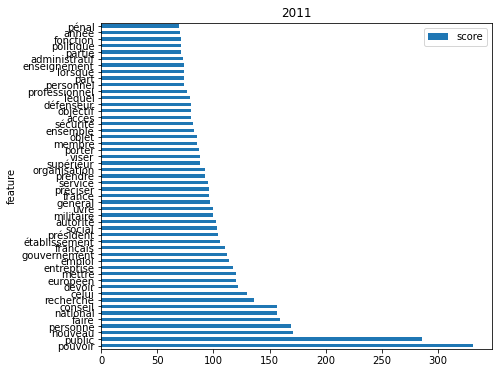

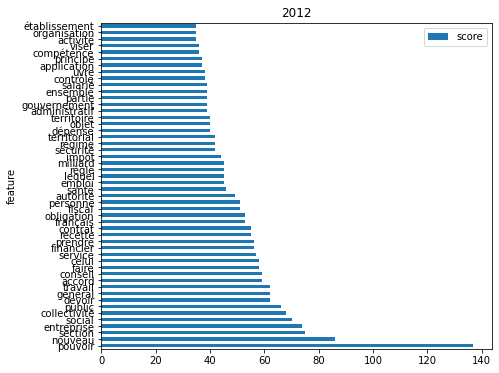

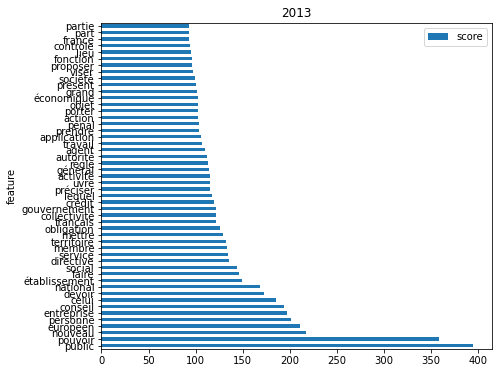

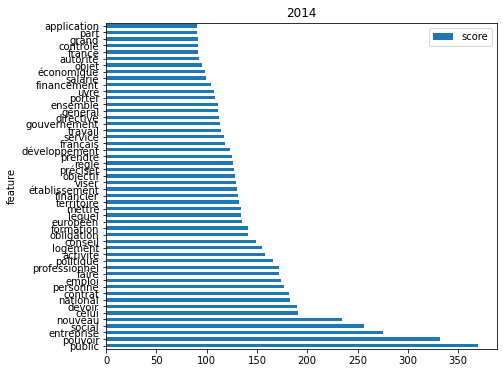

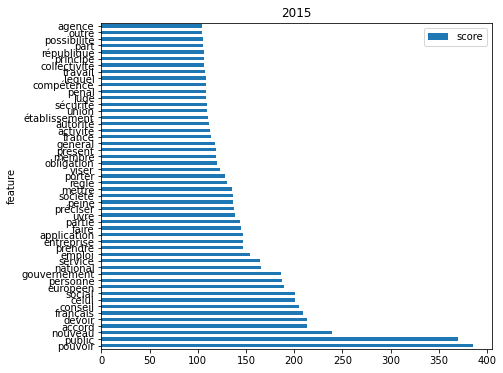

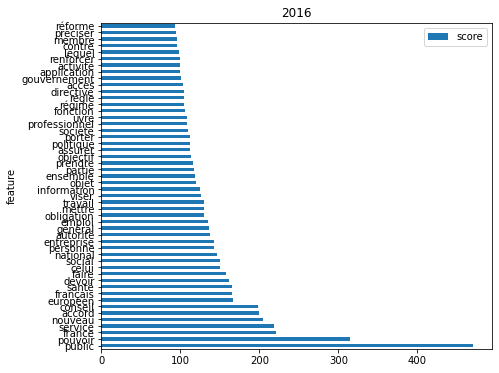

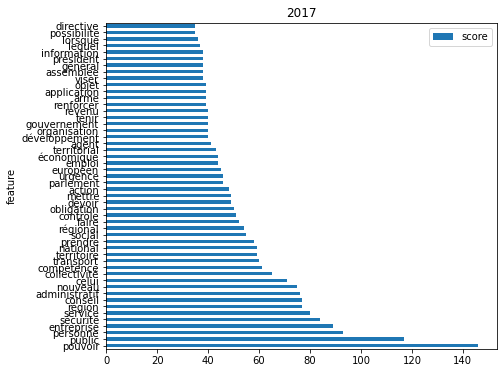

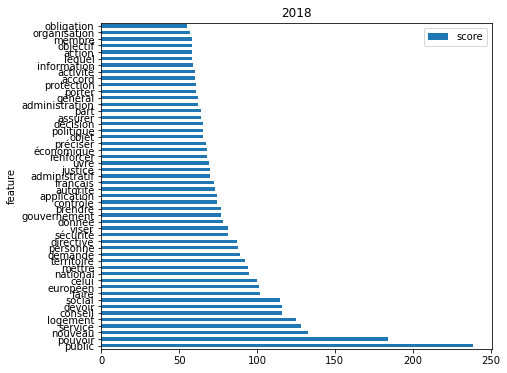

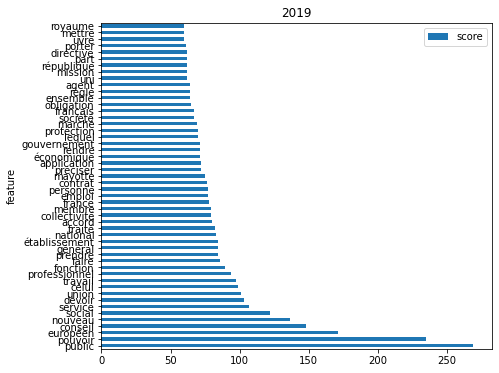

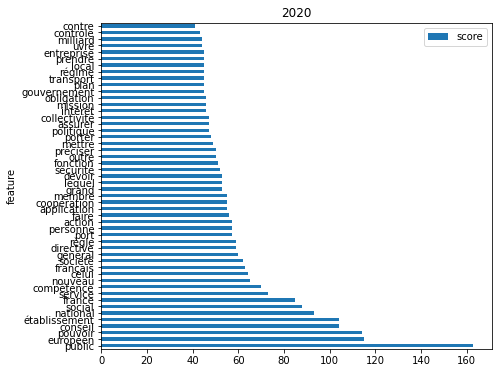

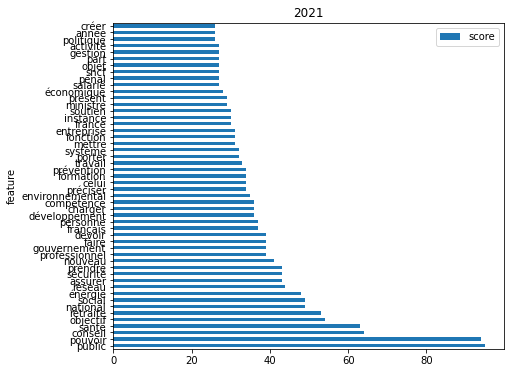

In [175]:
for year in tab:
    tab[year].plot(kind='barh', figsize=(7,6), title=year)